In [2]:
!pip install torch

  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 1.9 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached MarkupSafe-3.0.2-cp39-cp39-macosx_11_0_arm64.whl (12 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from tqdm import tqdm
import matplotlib.pyplot as plt


# Function to generate polynomial features up to a given order for two-dimensional input
def polynomial_features(x, order=2):
    n = x.size(0)
    features = [torch.ones(n)]
    for i in range(1, order + 1):
        for j in range(i + 1):
            features.append((x[:, 0]**(i-j)) * (x[:, 1]**j))
    return torch.cat([f.unsqueeze(1) for f in features], dim=1)


# Tri-cube weight function
def tri_cube(u):
    return torch.where(u < 1, (1 - u**3)**3, torch.zeros_like(u))


# Calculate weights for all points based on a fitting point and bandwidth
def calculate_weights(data_points, fitting_point, bandwidth):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    scaled_distances = distances / bandwidth
    weights = tri_cube(scaled_distances)
    return weights


# Perform weighted least squares regression (optimized)
def weighted_least_squares(X, y, weights):
    # Assume X is n x m and weights is n x 1
    weighted_X = X * weights.unsqueeze(1)  # element-wise multiplication to weight each row
    XTWX = weighted_X.T @ X  # This replaces the need for explicitly creating W
    XTWy = weighted_X.T @ y
    beta = torch.linalg.pinv(XTWX) @ XTWy
    return beta.squeeze()


# Calculate adaptive bandwidth based on the percentile of distances
def adaptive_bandwidth(data_points, fitting_point, percentile=30):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    return torch.quantile(distances, percentile / 100.0)


def process_data(data, covariates, response):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data[covariates] = scaler.fit_transform(data[covariates])
    
    features = torch.tensor(data[covariates].values, dtype=torch.float32)
    target = torch.tensor(data[response].values, dtype=torch.float32)
    
    return features, target, scaler


def fit_model(features, target, n_fitting_points=24):
    x = torch.linspace(-1, 1, n_fitting_points)
    y = torch.linspace(-1, 1, n_fitting_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    fitting_points = torch.column_stack([X.ravel(), Y.ravel()])
    
    X_poly_base = polynomial_features(features)
    
    coefficients = torch.zeros(len(fitting_points), X_poly_base.size(1), dtype=torch.float32)
    predicted_values = torch.zeros(len(fitting_points), dtype=torch.float32)
    
    for i, fp in enumerate(tqdm(fitting_points, desc="Fitting Points")):
        bandwidth = adaptive_bandwidth(features, fp, percentile=30)
        weights = calculate_weights(features, fp, bandwidth)
        X_poly = polynomial_features(fp.clone().detach().unsqueeze(0))
        beta = weighted_least_squares(X_poly_base, target, weights)
        coefficients[i] = beta
        predicted_values[i] = torch.matmul(X_poly, beta)
    
    return fitting_points, predicted_values


def plot_results(n_grid_points, fitting_points, predicted_values, scaler, filename, plane_zero=False):
    fitting_points = fitting_points.cpu()  # Transfer to CPU
    predicted_values = predicted_values.cpu()  # Transfer to CPU
    
    grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
    grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')
    
    original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
    original_grid_x = original_grid_x.reshape(grid_x.shape)
    original_grid_y = original_grid_y.reshape(grid_y.shape)
    
    fig = plt.figure(figsize=(6, 9), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap='plasma', edgecolor='k', linewidth=0.5)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap='plasma', alpha=0.7)
    
    # Add a plane for price zero
    if plane_zero:
        ax.plot_surface(original_grid_x, original_grid_y, np.zeros_like(original_grid_x), color='red', alpha=0.8, rstride=100, cstride=100)
    
    cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=40, pad=0.05, anchor=(0.5, 1.2))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('Forecasted WP penetration (%)')
    ax.set_ylabel('Hour of the day')
    ax.set_zlabel('Price (GBP/MWh)')
    ax.set_zlim(-80, 250)
    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.85)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

Fitting Points: 100%|██████████| 576/576 [00:01<00:00, 335.95it/s]


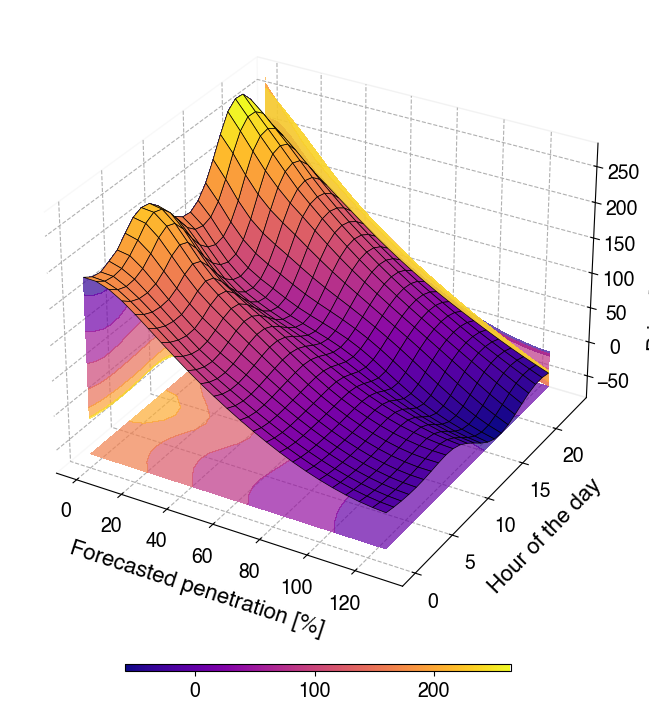

In [8]:
# from LWPR_mean.utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('/Users/emircanince/Desktop/power/renewables/data/causal_data.csv')

# Define covariates and response
covariates = ['wind_penetration', 'Hour']
response = 'electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_wind = ["#f0f0f0", "#1f77b4"]  # Light gray to blue
# colors_wind = ["#add8e6", "#1f77b4"]  # Light blue to dark blue
colors_wind = ["#e0ffff", "#1f77b4"]  # Light cyan to bright blue
n_bins = 100  # Number of bins for colormap
# cmap_wind = mcolors.LinearSegmentedColormap.from_list("wind_cmap", colors_wind, N=n_bins)
cmap_wind = 'plasma'
# cmap_wind = 'Blues'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_wind, edgecolor='k', linewidth=.5)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_wind, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
# plt.savefig(f'/Users/dcac/PycharmProjects/day-ahead-wind-forecast/causal_analysis_wind_solar/plots/LWPR_wind.png', format='png', dpi=600)
plt.show()

Fitting Points: 100%|██████████| 576/576 [00:01<00:00, 452.92it/s]


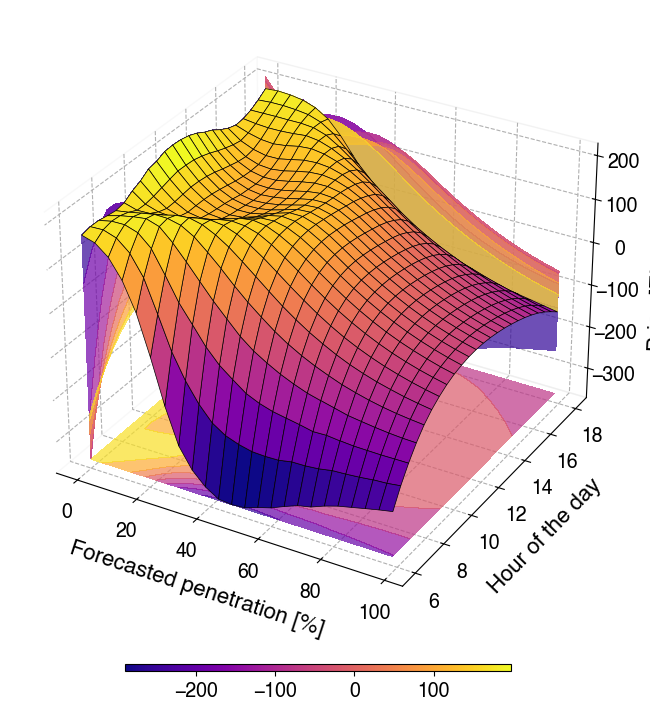

In [61]:
# from LWPR_mean.utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('/Users/emircanince/Desktop/power/renewables/data/causal_data.csv')
# df = df[(df['solar_penetration'] != 0) & (df['solar_penetration'] < 20)]
# df = df[(df['Year'] == 2022)]
df = df[(df['solar_penetration'] != 0)]
df = df[(df['Hour'] >= 6) & (df['Hour'] <= 18)]

# Define covariates and response
covariates = ['solar_penetration', 'Hour']
response = 'electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_wind = ["#f0f0f0", "#1f77b4"]  # Light gray to blue
# colors_wind = ["#add8e6", "#1f77b4"]  # Light blue to dark blue
colors_wind = ["#e0ffff", "#1f77b4"]  # Light cyan to bright blue
n_bins = 100  # Number of bins for colormap
# cmap_wind = mcolors.LinearSegmentedColormap.from_list("wind_cmap", colors_wind, N=n_bins)
cmap_wind = 'plasma'
# cmap_wind = 'Blues'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_wind, edgecolor='k', linewidth=.5)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_wind, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
# plt.savefig(f'/Users/dcac/PycharmProjects/day-ahead-wind-forecast/causal_analysis_wind_solar/plots/LWPR_wind.png', format='png', dpi=600)
plt.show()

In [40]:
import pandas as pd

df = pd.read_csv('/Users/emircanince/Desktop/power/renewables/data/causal_data.csv')
df = df[(df['solar_penetration'] != 0)]

bins = list(range(0, 110, 5))  # 0–10, 10–20, ..., 90–100

# Create labels for each bin
labels = [f"{i}-{i+5}%" for i in bins[:-1]]

# Bin the data
df['solar_penetration_bin'] = pd.cut(df['solar_penetration'], bins=bins, labels=labels, right=False)

# Display the result
print(df[['solar_penetration', 'solar_penetration_bin']].head())

    solar_penetration solar_penetration_bin
8                0.84                  0-5%
9                4.76                  0-5%
10               9.43                 5-10%
11              12.67                10-15%
12              14.11                10-15%


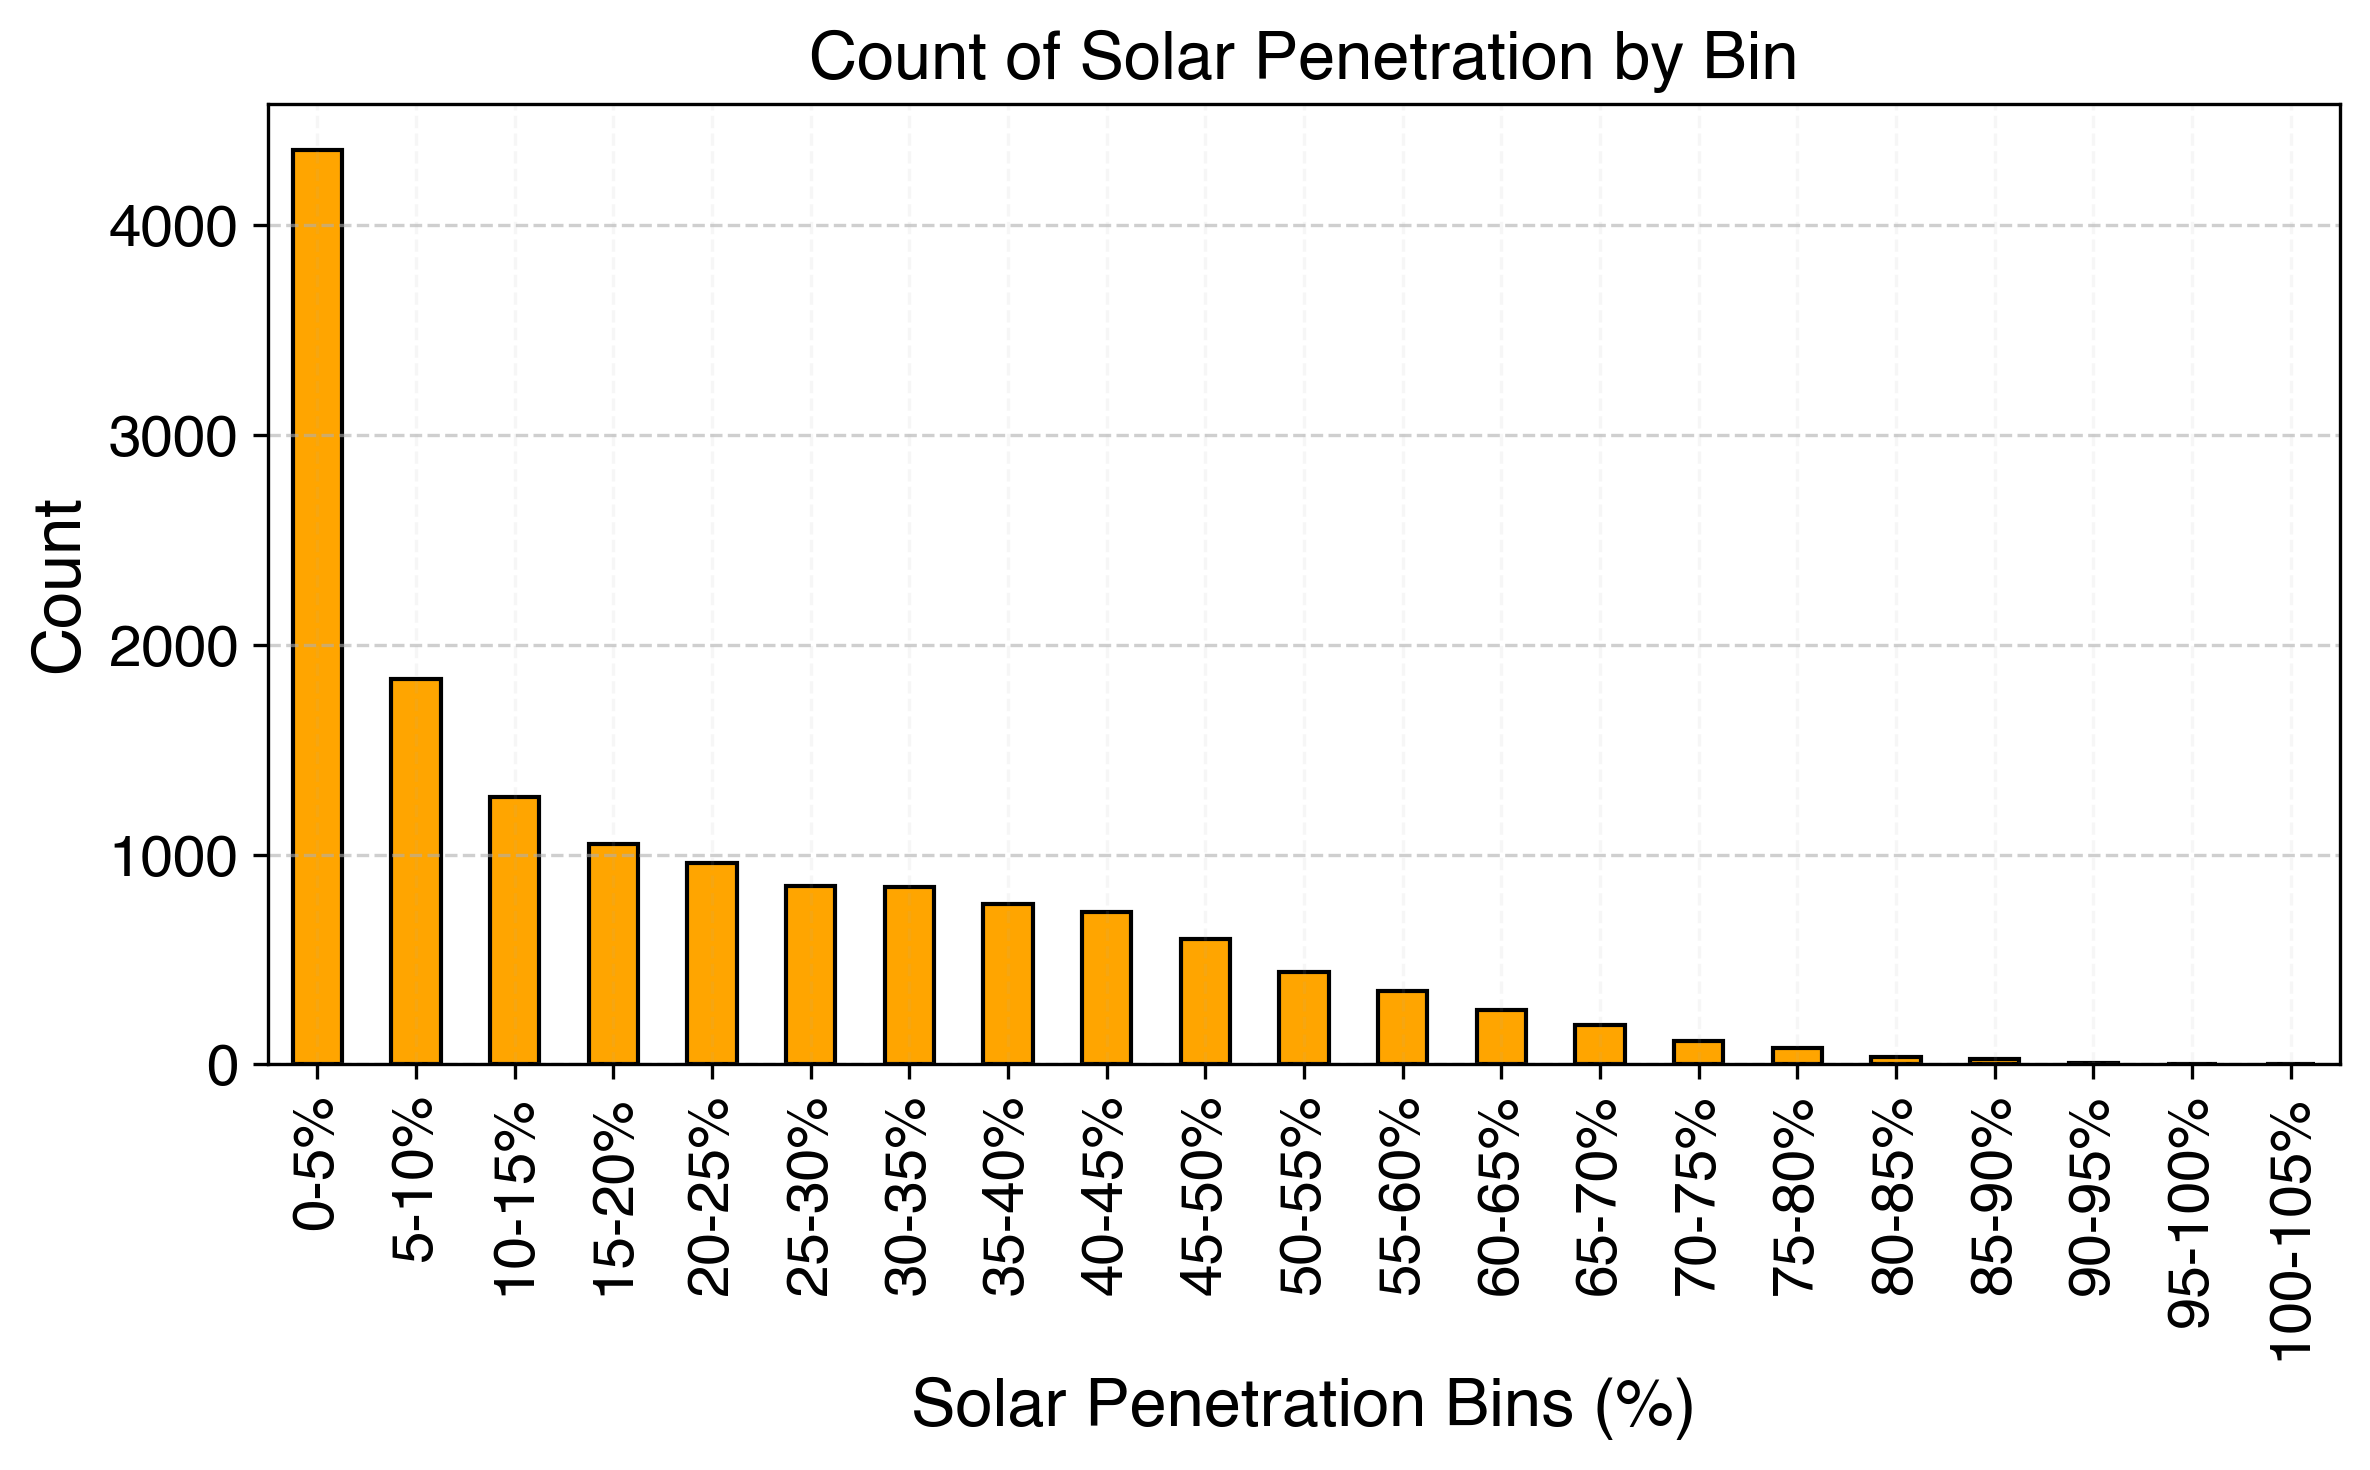

In [41]:
import matplotlib.pyplot as plt

# Count how many values fall into each bin
bin_counts = df['solar_penetration_bin'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(8, 5))
bin_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Count of Solar Penetration by Bin')
plt.xlabel('Solar Penetration Bins (%)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()